In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
import os

from ExptTrace import ExptTrace
from FileManager import FileManager
from misc import rcsetup

rcsetup()

sys.path.append("../")

from kernels import GaussianKernel, LaplaceKernel
from utils import ensure_torch, ensure_numpy
from eigenlearning import eigenlearning
from feature_decomp import Monomial

In [2]:
import matplotlib.colors as mcolors

colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

def lighten(color, amount=0.5):
    rgb = mcolors.to_rgb(mcolors.XKCD_COLORS.get(color, color))
    if amount >= 0:
        new_rgb = tuple(c + (1 - c) * amount for c in rgb)
    else:
        new_rgb = tuple(c * (1 + amount) for c in rgb)
    # Clip values to [0, 1]
    new_rgb = tuple(min(max(x, 0), 1) for x in new_rgb)
    return new_rgb

# Predict monomial targets

In [30]:
expt_id = 1
KERNEL_WIDTH = 10
N_SAMPLES = 25_000
P_MODES = 25_000
DATA_DIM = 200
TARGET = "monomials"

if expt_id == 1:
    DATASET = "gaussian"
    KERNEL_TYPE = GaussianKernel
elif expt_id == 2:
    DATASET = "gaussian"
    KERNEL_TYPE = LaplaceKernel
elif expt_id == 3:
    DATASET = "cifar10"
    KERNEL_TYPE = GaussianKernel
elif expt_id == 4:
    DATASET = "cifar10"
    KERNEL_TYPE = LaplaceKernel

if KERNEL_TYPE == GaussianKernel:
    # DATA_EIGVAL_EXP = 2.0   # d_eff = 15
    # ZCA_STRENGTH = 5e-3     # d_eff = 18
    DATA_EIGVAL_EXP = 3.   # d_eff = 7
    ZCA_STRENGTH = 0        # d_eff = IDK
if KERNEL_TYPE == LaplaceKernel:
    DATA_EIGVAL_EXP = 1.6   # d_eff = 27
    ZCA_STRENGTH = 1e-2     # d_eff = 26

In [ ]:
from feature_decomp import generate_fra_monomials
from data import get_powerlaw, get_matrix_hermites

data_eigvals = get_powerlaw(DATA_DIM, DATA_EIGVAL_EXP, offset=6)
eval_level_coeff = KERNEL_TYPE.get_level_coeff_fn(data_eigvals=data_eigvals,
                                                  kernel_width=KERNEL_WIDTH)
hehe_eigvals, monomials = generate_fra_monomials(data_eigvals, P_MODES, eval_level_coeff)
# on average, we expect norm(x_i) ~ Tr(data_eigvals)
X = ensure_torch(torch.normal(0, 1, (N_SAMPLES, DATA_DIM)))
X *= torch.sqrt(ensure_torch(data_eigvals))
H = get_matrix_hermites(X, monomials[:P_MODES])

d_eff = 1/(data_eigvals**2).sum().item()
print(f"d_eff: {d_eff:.2f}", end="\n")

target_monomials = [{10:1}, {190:1}, {0:2}, {2:1, 3:1}, {15:1,20:1}, {0:3}]#, {0:1, 1:1, 2:1}]

targets = {}
if TARGET == "monomials":
    monomial_idxs = []
    for tmon in target_monomials:
        try:
            monomial_idxs.append(monomials.index(tmon))
        except ValueError:
            print(f"Warning: target {tmon} not in generated monomials. Skipping.")
    assert len(monomial_idxs) > 0
    
    if sorted(monomial_idxs) == monomial_idxs:
        print("target monomials are monotonic :(")
    for idx in monomial_idxs:
        ystar = ensure_numpy(H[:, idx])
        # ensure size(y_i) ~ 1
        targets[idx] = np.sqrt(N_SAMPLES) * ystar / np.linalg.norm(ystar)
    print(f"target idxs: {monomial_idxs}")
    # print(f"target eigvals: {hehe_eigvals[monomial_idxs]}")
target_idxs = np.array(list(targets.keys()), dtype=int)

Generating monomials: 100%|██████████| 25000/25000 [00:02<00:00, 8453.94step/s]


d_eff: 7.03
target idxs: [11, 267, 38, 91, 760, 474]


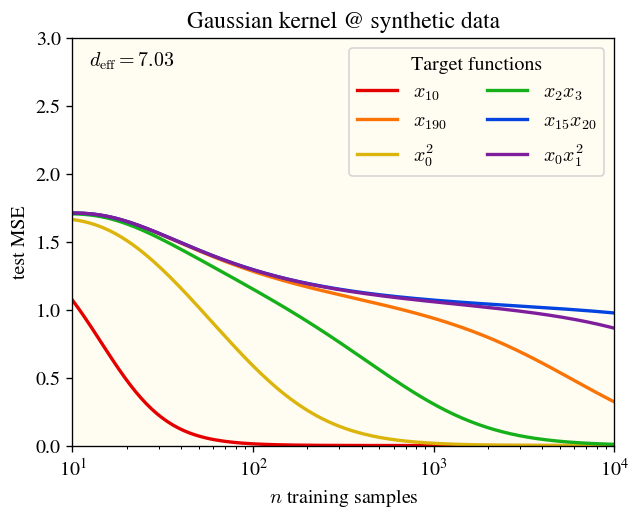

In [41]:
fig, ax = plt.subplots(figsize=(5.5, 4.5))

TrK = 1.0
use_hehe_coeffs = True
ntrains_dense = np.logspace(np.log10(10), np.log10(10000), 200)
ridge = 1e-3
for i, idx in enumerate(target_idxs):
    eigvals = hehe_eigvals[:N_SAMPLES]
    coeffs = np.zeros_like(eigvals)
    coeffs[idx] = 1.0
    
    hehe_ridge = ridge + max(0, TrK - eigvals.sum())
    el_hehe = lambda n: eigenlearning(n, eigvals, coeffs, ridge=hehe_ridge)
    mse_el_hehe = np.array([el_hehe(n)["test_mse"] for n in ntrains_dense])
    ax.plot(ntrains_dense, mse_el_hehe, color=colors[i], lw=2, label=str(Monomial(monomials[idx])))

kname = "Gaussian" if KERNEL_TYPE == GaussianKernel else "Laplace"
dataname = "CIFAR10" if DATASET == "cifar10" else "synthetic data"
omniscient = "" if use_hehe_coeffs else " (omniscient empirical coeffs)"
ax.set_title(f"{kname} kernel @ {dataname}{omniscient}", fontsize=14)

ax.text(0.03, 0.97, f"$d_\\mathrm{{eff}} = {d_eff:.2f}$", ha="left", va="top", transform=ax.transAxes)
ax.set_xlabel(f"$n$ training samples")
ax.set_ylabel("test MSE")

ax.set_xscale("log")
ax.set_xlim(10, 1e4)
ymax = 3 if KERNEL_TYPE == GaussianKernel else 2
ax.set_ylim(0, ymax)
ax.legend(title="Target functions", ncol=2, loc="upper right")
plt.tight_layout()
plt.show()

# Monomial targets

In [ ]:
expt_id = 4
EXPT_NAME = "hehe-eigenlearning"
KERNEL_WIDTH = 10
N_SAMPLES = 25_000
P_MODES = 25_000
DATA_DIM = 200
TARGET = "monomials"

if expt_id == 1:
    DATASET = "gaussian"
    KERNEL_TYPE = GaussianKernel
elif expt_id == 2:
    DATASET = "gaussian"
    KERNEL_TYPE = LaplaceKernel
elif expt_id == 3:
    DATASET = "cifar10"
    KERNEL_TYPE = GaussianKernel
elif expt_id == 4:
    DATASET = "cifar10"
    KERNEL_TYPE = LaplaceKernel

if KERNEL_TYPE == GaussianKernel:
    # DATA_EIGVAL_EXP = 2.0   # d_eff = 15
    # ZCA_STRENGTH = 5e-3     # d_eff = 18
    DATA_EIGVAL_EXP = 3.0   # d_eff = 7
    ZCA_STRENGTH = 0        # d_eff = 7
if KERNEL_TYPE == LaplaceKernel:
    DATA_EIGVAL_EXP = 1.6   # d_eff = 27
    ZCA_STRENGTH = 1e-2     # d_eff = 26

datapath = os.getenv("DATASETPATH")
exptpath = os.getenv("EXPTPATH")
if datapath is None:
    raise ValueError("must set $DATASETPATH environment variable")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
fp = f"{KERNEL_TYPE.__name__}-kw:{KERNEL_WIDTH}-target:{TARGET}"
if DATASET == "gaussian":
    fp += f"-data:{DATA_DIM}:{DATA_EIGVAL_EXP}"
else:
    fp += f"-zca:{ZCA_STRENGTH}"
expt_dir = os.path.join(exptpath, "phlab", EXPT_NAME, DATASET, fp)

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)

In [9]:
result = expt_fm.load("result.pickle")
monomials = result["monomials"]
d_eff = result["d_eff"]
ridge = result["ridge"]
print(f"d_eff = {d_eff:.2f}")
et_yhat = ExptTrace.deserialize(result["y_hat"])

emp_eigvals = result["emp_eigvals"]
hehe_eigvals = result["th_eigvals"]
iso_eigvals = result["iso_eigvals"]

targets = expt_fm.load("targets.pickle")
target_idxs = np.array(list(targets.keys()), dtype=int)
print([monomials[idx] for idx in target_idxs])

emp_eigvecs = expt_fm.load("emp_eigvecs.npy")
H = expt_fm.load("H.npy")

ntest = result["n_test"]
ntrains = et_yhat.get_axis("ntrain")
trials = et_yhat.get_axis("trial")

d_eff = 25.97
[{10: 1}, {190: 1}, {0: 2}, {2: 1, 3: 1}, {20: 1, 30: 1}, {0: 3}, {1: 2, 2: 1}]


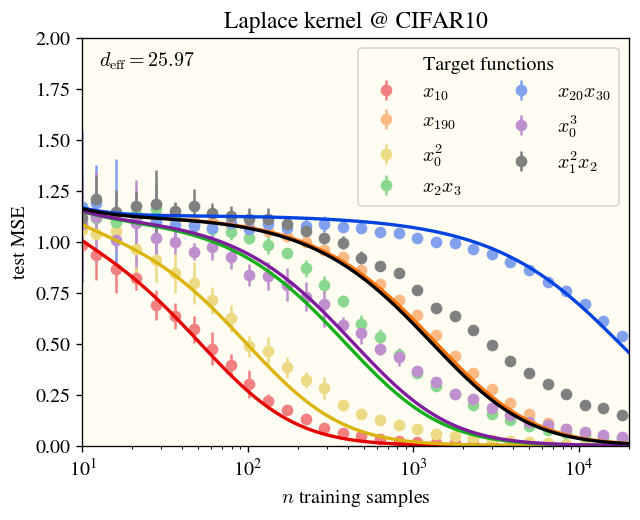

In [ ]:
fig, ax = plt.subplots(figsize=(5.5, 4.5))

xmin, xmax = 10, 2e4
TrK = 1.0
use_hehe_coeffs = True
use_ots_correction = False
ntrains_dense = np.logspace(np.log10(xmin), np.log10(xmax), 200)
for i, idx in enumerate(target_idxs):
    ystar = targets[idx]
    yhat = et_yhat[:, :, idx].squeeze()
    mse = ((yhat - ystar[-ntest:])**2).mean(axis=-1)
    lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)
    ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(colors[i], 0.5),
                ls='none', marker='o', zorder=-4, label=str(Monomial(monomials[idx])))

    eigvals = hehe_eigvals[:N_SAMPLES]
    if use_hehe_coeffs:
        coeffs = np.zeros_like(eigvals)
        coeffs[idx] = 1.0
    else:
        coeffs = emp_eigvecs.T @ ystar
        coeffs /= np.linalg.norm(coeffs)
    hehe_ridge = ridge + max(0, TrK - eigvals.sum())
    el_hehe = lambda n: eigenlearning(n, eigvals, coeffs, ridge=hehe_ridge)
    mse_el_hehe = np.array([el_hehe(n)["test_mse"] for n in ntrains_dense])
    if use_ots_correction:
        train_mse = np.array([el_hehe(n)["train_mse"] for n in ntrains_dense])
        mse_el_hehe = (N_SAMPLES*mse_el_hehe - train_mse*ntrains_dense) / (N_SAMPLES - ntrains_dense)
    ax.plot(ntrains_dense, mse_el_hehe, color=colors[i], lw=2)

kname = "Gaussian" if KERNEL_TYPE == GaussianKernel else "Laplace"
dataname = "CIFAR10" if DATASET == "cifar10" else "synthetic data"
omniscient = "" if use_hehe_coeffs else " (omniscient empirical coeffs)"
ax.set_title(f"{kname} kernel @ {dataname}{omniscient}", fontsize=14)

ax.text(0.03, 0.97, f"$d_\\mathrm{{eff}} = {d_eff:.2f}$", ha="left", va="top", transform=ax.transAxes)
ax.set_xlabel(f"$n$ training samples")
ax.set_ylabel("test MSE")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ymax = 2
ax.set_ylim(0, ymax)
# ax.set_ylim(1e-2, ymax)
# ax.set_yscale("log")
ax.legend(title="Target functions", ncol=2, loc="upper right")
plt.tight_layout()
plt.show()

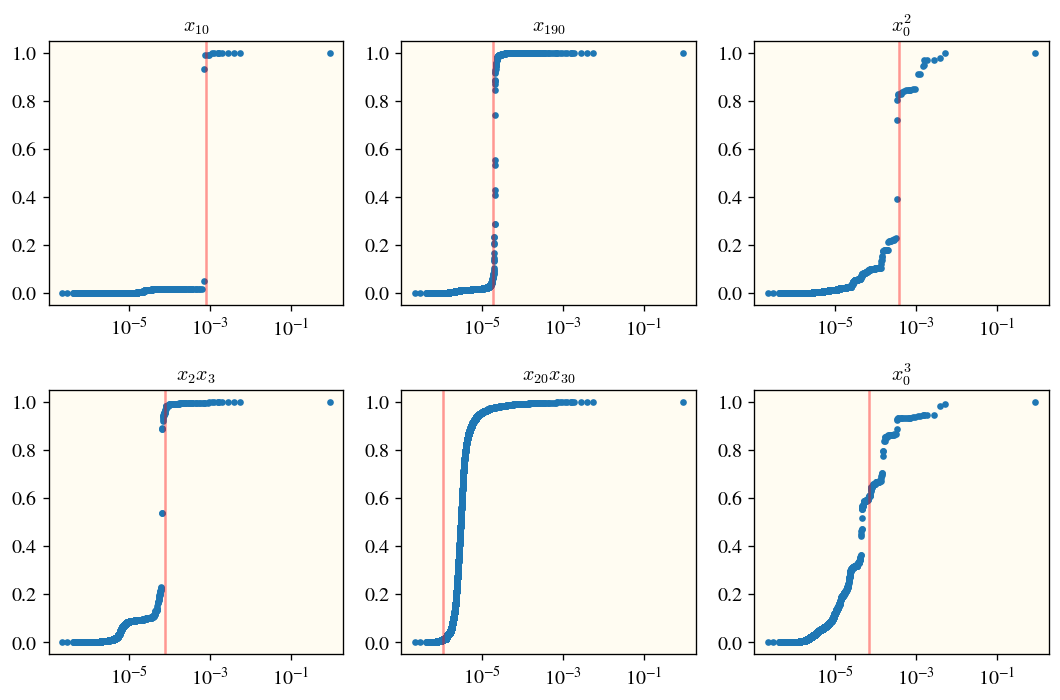

: 

: 

In [ ]:
H2 = ensure_torch(H)
H2 /= torch.linalg.norm(H2, axis=0)
overlaps = (ensure_torch(emp_eigvecs.T) @ H2)**2
# overlap has shape (neigvecs, nhermites)
cdfs = overlaps.flip(0,).cumsum(axis=0).flip(0,)
cdfs = ensure_numpy(cdfs.T)

fig, axes = plt.subplots(2, 3, figsize=(9, 6))

for ax, idx in zip(axes.flat, target_idxs[:]):
    ax.set_title(str(Monomial(monomials[idx])))
    ax.scatter(emp_eigvals, cdfs[idx], marker='.')
    ax.axvline(hehe_eigvals[idx], color='red', ls='-', alpha=0.4)
    ax.set_xscale('log')

plt.tight_layout()
plt.show()

# Powerlaw data

In [30]:
expt_id = 2
EXPT_NAME = "hehe-eigenlearning"
KERNEL_WIDTH = 10
N_SAMPLES = 25_000
P_MODES = 25_000
DATA_DIM = 200
TARGET = "powerlaws"

if expt_id == 1:
    DATASET = "gaussian"
    KERNEL_TYPE = GaussianKernel
elif expt_id == 2:
    DATASET = "gaussian"
    KERNEL_TYPE = LaplaceKernel
elif expt_id == 3:
    DATASET = "cifar10"
    KERNEL_TYPE = GaussianKernel
elif expt_id == 4:
    DATASET = "cifar10"
    KERNEL_TYPE = LaplaceKernel

if KERNEL_TYPE == GaussianKernel:
    DATA_EIGVAL_EXP = 3.0   # d_eff = 7
    ZCA_STRENGTH = 0        # d_eff = 7
if KERNEL_TYPE == LaplaceKernel:
    DATA_EIGVAL_EXP = 1.6   # d_eff = 27
    ZCA_STRENGTH = 1e-2     # d_eff = 26

datapath = os.getenv("DATASETPATH")
exptpath = os.getenv("EXPTPATH")
if datapath is None:
    raise ValueError("must set $DATASETPATH environment variable")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
fp = f"{KERNEL_TYPE.__name__}-kw:{KERNEL_WIDTH}-target:{TARGET}"
if DATASET == "gaussian":
    fp += f"-data:{DATA_DIM}:{DATA_EIGVAL_EXP}"
else:
    fp += f"-zca:{ZCA_STRENGTH}"
expt_dir = os.path.join(exptpath, "phlab", EXPT_NAME, DATASET, fp)

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)

In [31]:
result = expt_fm.load("result.pickle")
monomials = result["monomials"]
d_eff = result["d_eff"]
print(f"d_eff = {d_eff:.2f}")
ridge = result["ridge"]
et_yhat = ExptTrace.deserialize(result["y_hat"])

emp_eigvals = result["emp_eigvals"]
hehe_eigvals = result["th_eigvals"]
iso_eigvals = result["iso_eigvals"]

targets = expt_fm.load("targets.pickle")
source_exps = np.array(list(targets.keys()))

emp_eigvecs = expt_fm.load("emp_eigvecs.npy")
H = expt_fm.load("H.npy")

ntest = result["n_test"]
ntrains = et_yhat.get_axis("ntrain")
trials = et_yhat.get_axis("trial")

d_eff = 26.57


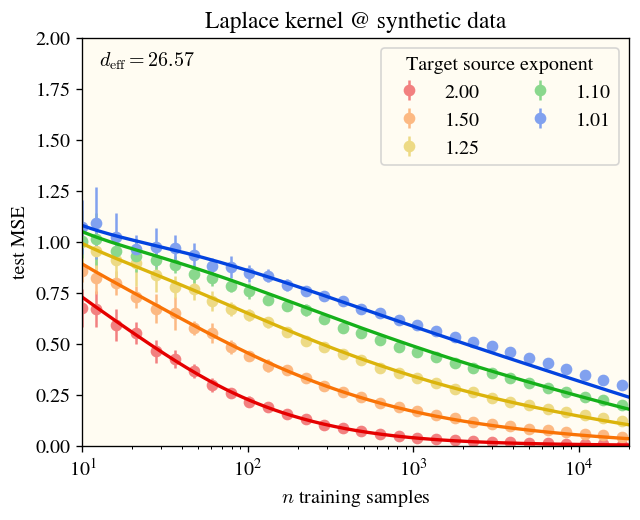

In [33]:
from data import get_powerlaw

fig, ax = plt.subplots(figsize=(5.5, 4.5))

xmin, xmax = 10, 2e4
TrK = 1.0
use_hehe_coeffs = True
use_ots_correction = False
ntrains_dense = np.logspace(np.log10(xmin), np.log10(xmax), 200)
for i, source_exp in enumerate(source_exps[::-1]):
    ystar = targets[source_exp]
    yhat = et_yhat[:, :, source_exp].squeeze()
    mse = ((yhat - ystar[-ntest:])**2).mean(axis=-1)
    lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)
    ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(colors[i], 0.5),
                ls='none', marker='o', zorder=-4, label=f"{source_exp:.2f}")

    eigvals = hehe_eigvals[:N_SAMPLES]
    if use_hehe_coeffs:
        coeffs = ensure_numpy(torch.sqrt(get_powerlaw(P_MODES, source_exp, offset=6)))
    else:
        coeffs = emp_eigvecs.T @ ystar
    coeffs /= np.linalg.norm(coeffs)
    hehe_ridge = ridge + max(0, TrK - eigvals.sum())
    el_hehe = lambda n: eigenlearning(n, eigvals, coeffs, ridge=hehe_ridge)
    mse_el_hehe = np.array([el_hehe(n)["test_mse"] for n in ntrains_dense])
    if use_ots_correction:
        train_mse = np.array([el_hehe(n)["train_mse"] for n in ntrains_dense])
        mse_el_hehe = (N_SAMPLES*mse_el_hehe - train_mse*ntrains_dense) / (N_SAMPLES - ntrains_dense)
    ax.plot(ntrains_dense, mse_el_hehe, color=colors[i], lw=2)

kname = "Gaussian" if KERNEL_TYPE == GaussianKernel else "Laplace"
dataname = "CIFAR10" if DATASET == "cifar10" else "synthetic data"
omniscient = "" if use_hehe_coeffs else " (omniscient empirical coeffs)"
ax.set_title(f"{kname} kernel @ {dataname}{omniscient}", fontsize=14)

ax.text(0.03, 0.97, f"$d_\\mathrm{{eff}} = {d_eff:.2f}$", ha="left", va="top", transform=ax.transAxes)
ax.set_xlabel(f"$n$ training samples")
ax.set_ylabel("test MSE")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 2)
# ax.set_ylim(1e-2, 2)
# ax.set_yscale("log")
ax.legend(title="Target source exponent", ncol=2)
plt.tight_layout()
plt.show()